In [1]:
# Diabetes Multi-class Classification and Evaluation metrics

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

# Style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. LOAD AND EXPLORE DATA

import pandas as pd
url = "https://raw.githubusercontent.com/avinashkamalbharti/dataset/main/diabetes_raw.csv"
df = pd.read_csv(url)

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nClass Distribution:")
print(df['Class'].value_counts())
print("\nClass Distribution (%):")
print(df['Class'].value_counts(normalize=True) * 100)

print("\nStatistical Summary:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (264, 12)

First few rows:
   Gender  AGE  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL   BMI  Class
0       0   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0      0
1       1   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6  23.0      0
2       1   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4  21.0      0
3       0   45   2.3  24    4.0   2.9  1.0  1.0  1.5   0.4  21.0      0
4       0   50   2.0  50    4.0   3.6  1.3  0.9  2.1   0.6  24.0      0

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  264 non-null    int64  
 1   AGE     264 non-null    int64  
 2   Urea    264 non-null    float64
 3   Cr      264 non-null    int64  
 4   HbA1c   264 non-null    float64
 5   Chol    264 non-null    float64
 6   TG      264 non-null    float64
 7   HDL     264 non-null    float64
 8   LDL     264 non-null    float64

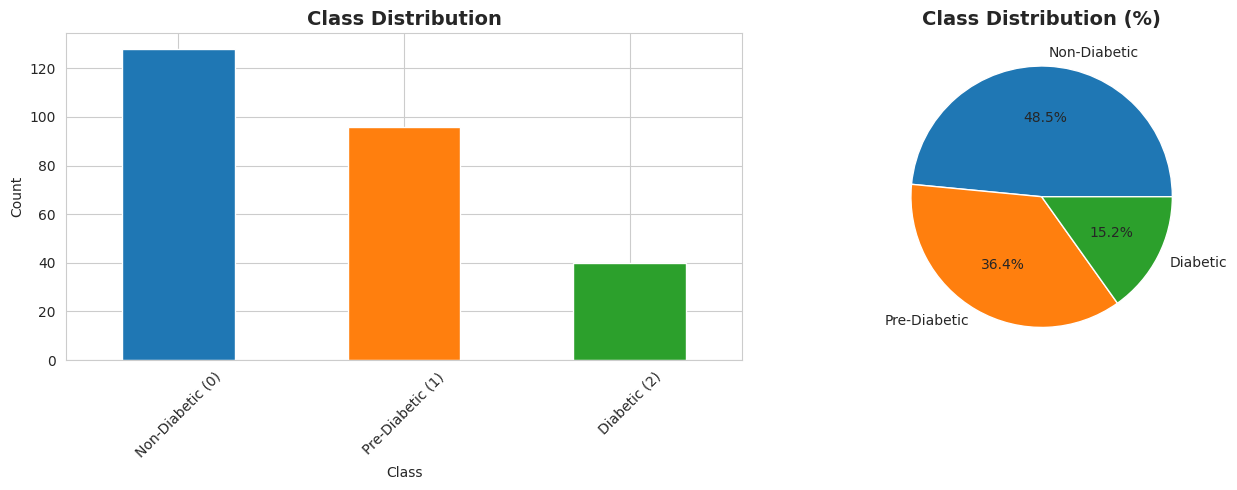

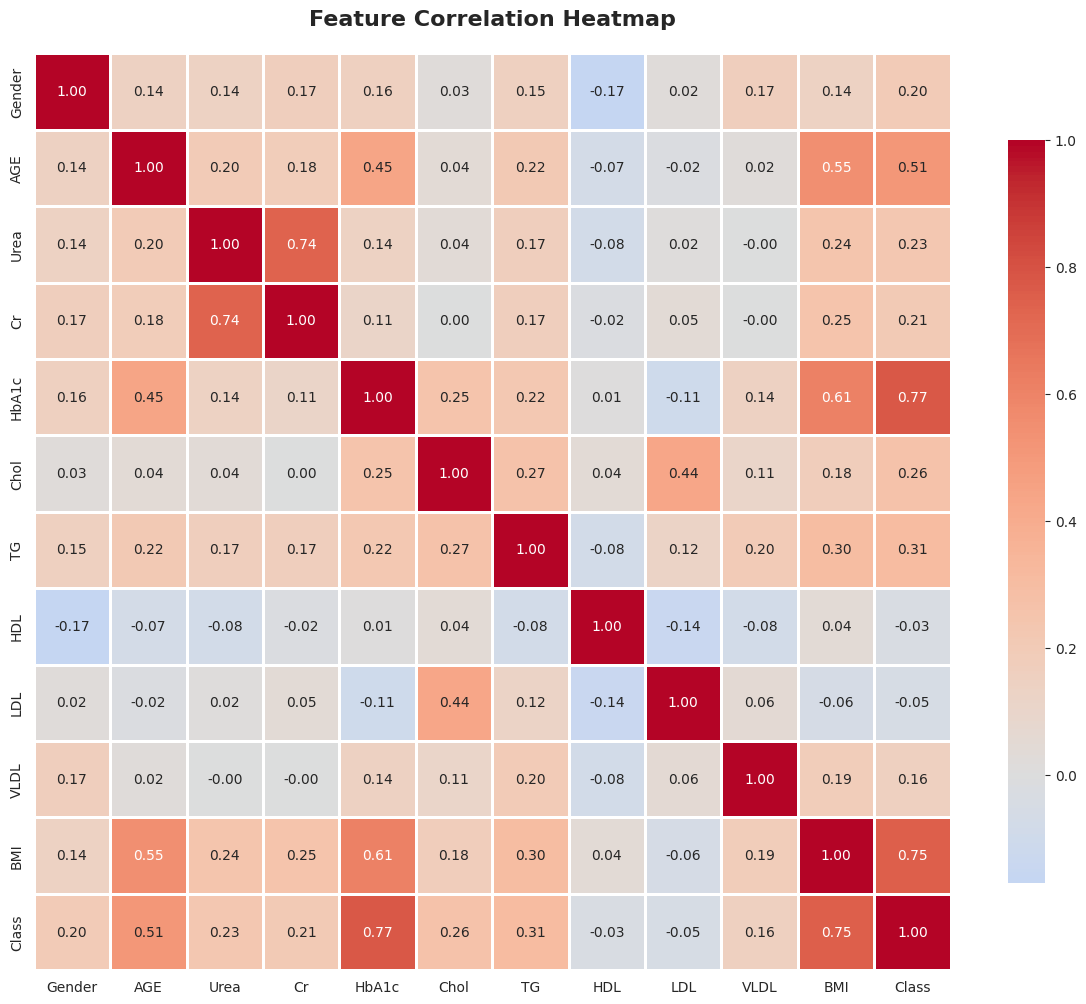

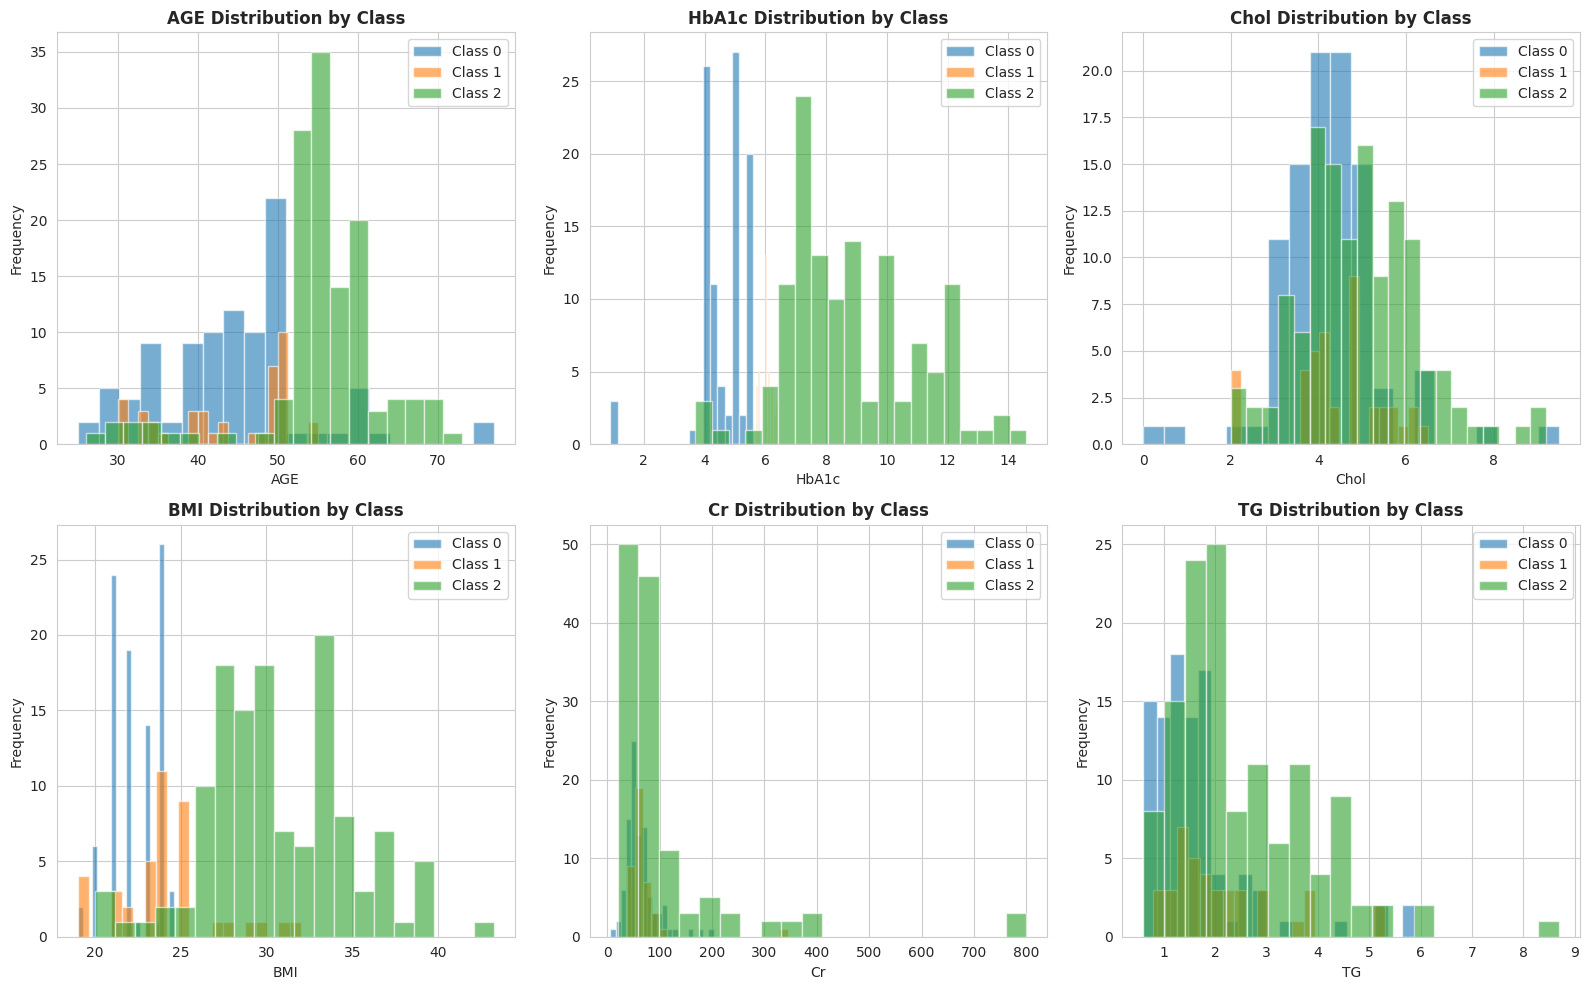

In [2]:

# 2. DATA VISUALIZATION

# Class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
df['Class'].value_counts().plot(kind='bar', ax=axes[0], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-Diabetic (0)', 'Pre-Diabetic (1)', 'Diabetic (2)'], rotation=45)

# Pie chart
df['Class'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                 labels=['Non-Diabetic', 'Pre-Diabetic', 'Diabetic'],
                                 colors=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1].set_title('Class Distribution (%)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation = df.corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Feature distributions by class
features = ['AGE', 'HbA1c', 'Chol', 'BMI', 'Cr', 'TG']
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(features):
    for class_val in [0, 1, 2]:
        axes[idx].hist(df[df['Class'] == class_val][feature], alpha=0.6,
                      label=f'Class {class_val}', bins=20)
    axes[idx].set_title(f'{feature} Distribution by Class', fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [3]:

# 3. DATA PREPROCESSING

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training set size: 184
Test set size: 80


In [4]:

# 4. MODEL TRAINING

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print('='*60)

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)

    # Store results
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']))



Training Logistic Regression...

Accuracy: 0.9000
Precision: 0.8990
Recall: 0.9000
F1-Score: 0.8977
Cross-Validation Accuracy: 0.8913 (+/- 0.0296)

Classification Report:
              precision    recall  f1-score   support

Non-Diabetic       0.88      0.97      0.92        29
Pre-Diabetic       0.80      0.67      0.73        12
    Diabetic       0.95      0.92      0.94        39

    accuracy                           0.90        80
   macro avg       0.87      0.85      0.86        80
weighted avg       0.90      0.90      0.90        80


Training Random Forest...

Accuracy: 0.9500
Precision: 0.9509
Recall: 0.9500
F1-Score: 0.9498
Cross-Validation Accuracy: 0.9836 (+/- 0.0134)

Classification Report:
              precision    recall  f1-score   support

Non-Diabetic       0.94      1.00      0.97        29
Pre-Diabetic       0.92      0.92      0.92        12
    Diabetic       0.97      0.92      0.95        39

    accuracy                           0.95        80
   macro 


MODEL COMPARISON
              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.9000   0.899030  0.9000  0.897722
      Random Forest    0.9500   0.950937  0.9500  0.949759
  Gradient Boosting    0.9375   0.937804  0.9375  0.937344
                SVM    0.8750   0.876699  0.8750  0.873381


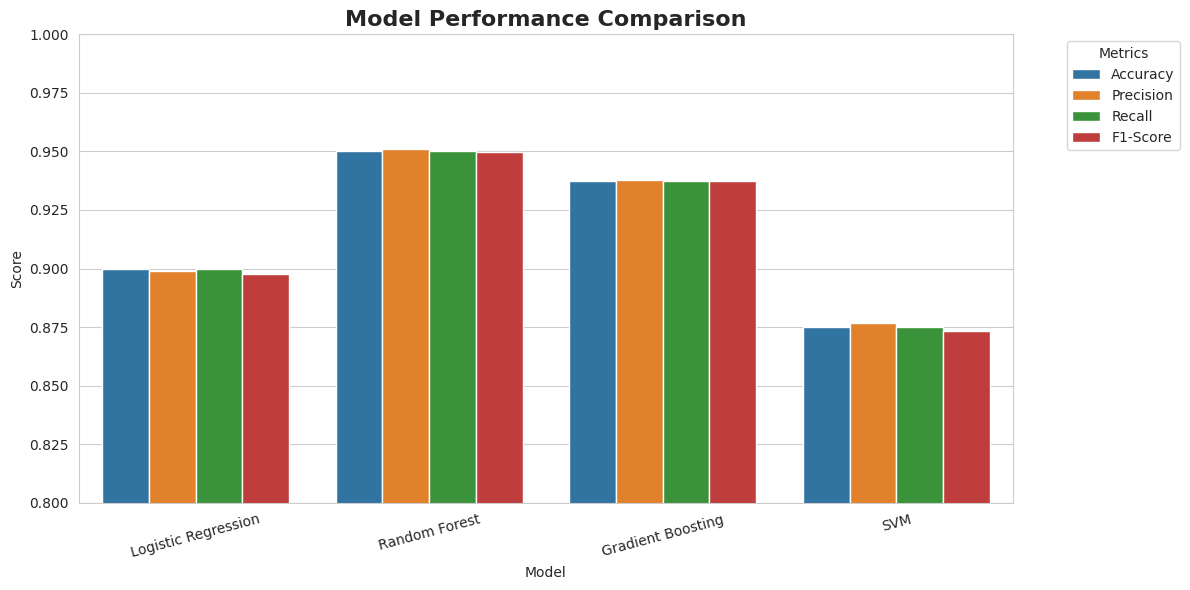

In [5]:

# 5. DETAILED EVALUATION


# Compare model performances
comparison_df = pd.DataFrame({
    'Model': list(models.keys()),
    'Accuracy': [accuracy_score(y_test, results[name]['y_pred']) for name in models.keys()],
    'Precision': [precision_recall_fscore_support(y_test, results[name]['y_pred'], average='weighted')[0]
                  for name in models.keys()],
    'Recall': [precision_recall_fscore_support(y_test, results[name]['y_pred'], average='weighted')[1]
               for name in models.keys()],
    'F1-Score': [precision_recall_fscore_support(y_test, results[name]['y_pred'], average='weighted')[2]
                 for name in models.keys()]
})

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

# Visualize model comparison
comparison_df_melted = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=15)
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

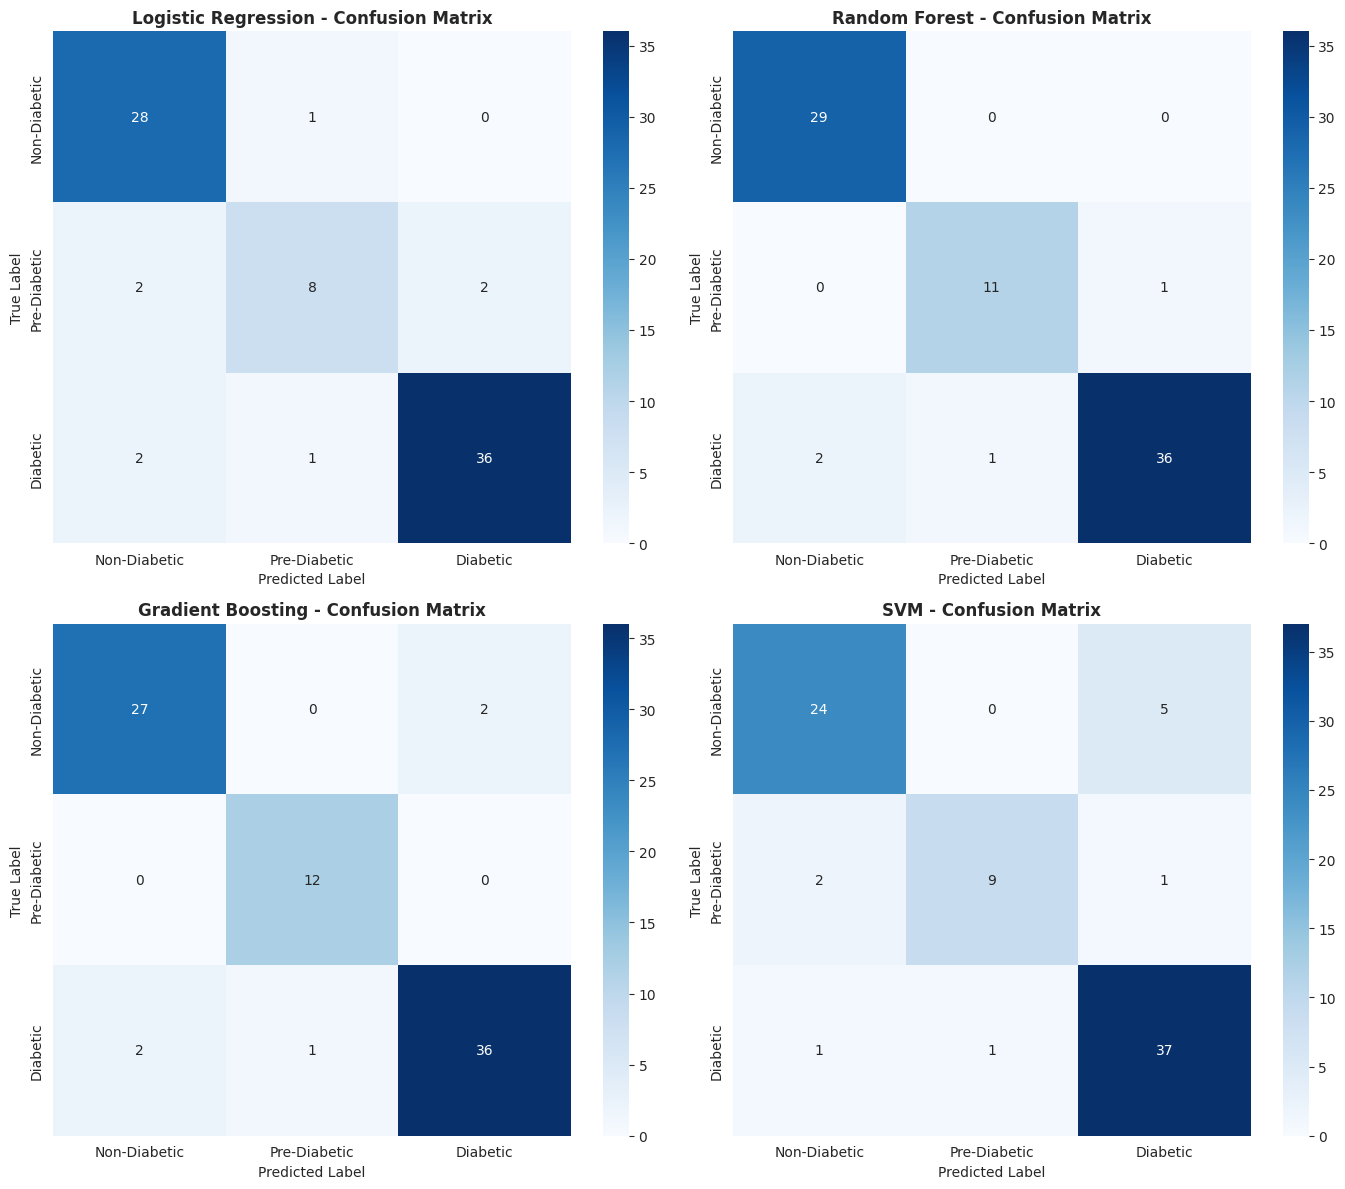

In [6]:

# 6. CONFUSION MATRICES


fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Non-Diabetic', 'Pre-Diabetic', 'Diabetic'],
                yticklabels=['Non-Diabetic', 'Pre-Diabetic', 'Diabetic'])
    axes[idx].set_title(f'{name} - Confusion Matrix', fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


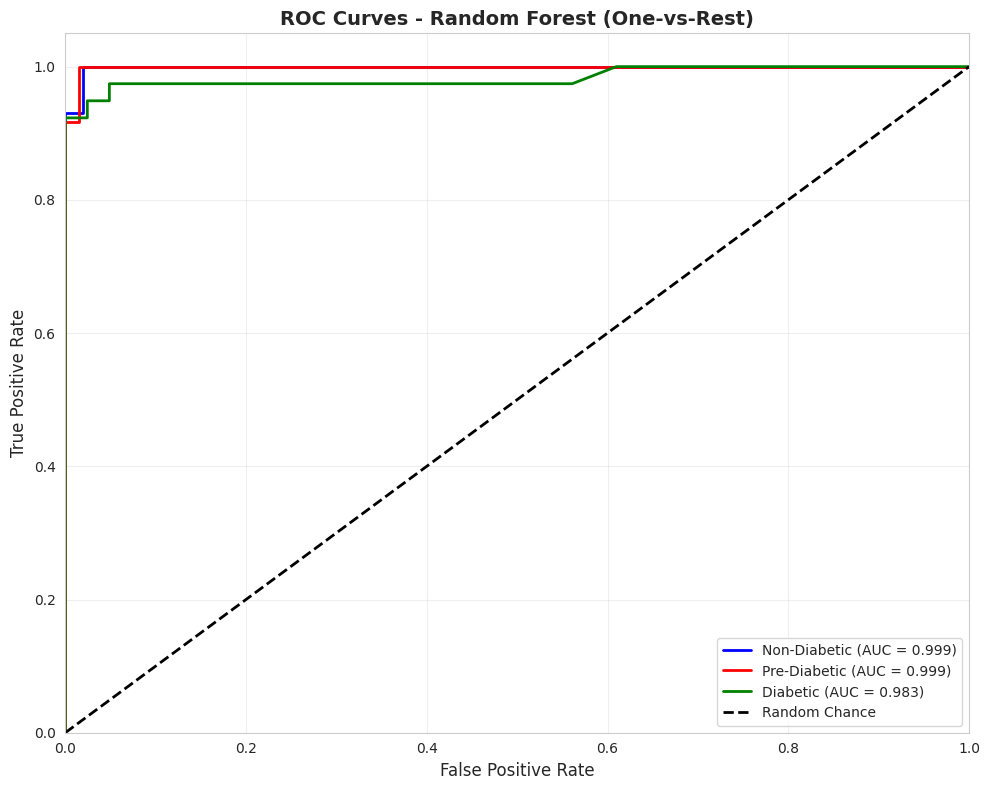

In [7]:

# 7. ROC CURVES (One-vs-Rest)


# Binarize the output for ROC curve
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = 3

# Plot ROC curves for the best model (Random Forest)
best_model_name = 'Random Forest'
y_pred_proba_best = results[best_model_name]['y_pred_proba']

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
class_names = ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']

for i, color, class_name in zip(range(n_classes), colors, class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_best[:, i])
    roc_auc = roc_auc_score(y_test_bin[:, i], y_pred_proba_best[:, i])
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{class_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curves - {best_model_name} (One-vs-Rest)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


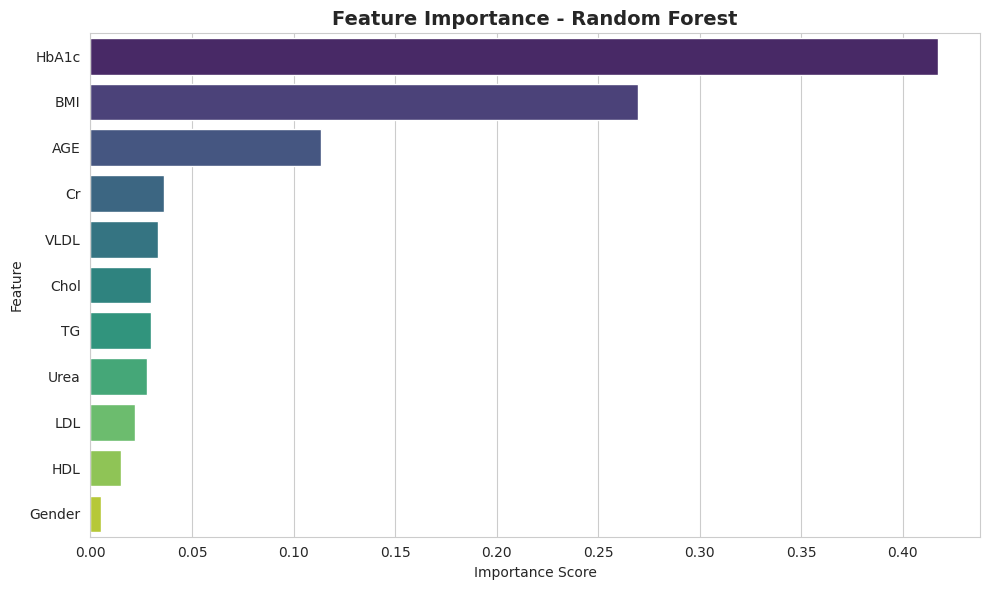


Feature Importance Rankings:
Feature  Importance
  HbA1c    0.417144
    BMI    0.269629
    AGE    0.113702
     Cr    0.036481
   VLDL    0.033167
   Chol    0.029919
     TG    0.029746
   Urea    0.027904
    LDL    0.021823
    HDL    0.015184
 Gender    0.005301


In [8]:

# 8. FEATURE IMPORTANCE


# Feature importance for Random Forest
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("\nFeature Importance Rankings:")
print(feature_importance.to_string(index=False))